In [5]:
from typing import List, Optional, Dict, Any, Tuple, Callable
import numpy as np
import collections
import pandas as pd
import json

# 임시
def historical_return(assets, window=20):
    pass

def historical_variance(assets, window=20):
    pass

def semi_covariance(assets):
    pass

def historical_covariance(assets, window=20):
    pass

class Node:
    def __init__(self, name: str):
        self.name = name
        self.children: List[Node] = []
        self.expected_return = None
        self.variance = None
        self.P = None
        self.Q = None
        self.omega = None

    def add_child(self, child_node) -> None:
        self.children.append(child_node)
        
    def _update(self) -> None:
       """ 
       self.expected_return = params.get('expected_return', None)
        self.variance = params.get('variance', None)
        self.P = params.get('P', None)
        self.Q = params.get('Q', None) 
        self.omega = params.get('omega', None
        """
        
class Tree:
    def __init__(self, root_name: str, loader: Loader):
        self.root = Node(root_name)
        self.loader = loader
        self.params = None
        self.param_keys = None
        
    def __repr__(self) -> str:
        return f'Tree({self.root.name})'

    def insert(self, parent_name: str, child_name: str) -> bool:
        parent_node = self._find_node(self.root, parent_name)
        if parent_node:
            child_node = Node(child_name)
            parent_node.add_child(child_node)
            return True
        return False
    
    # New
    def set_params(self, **params: Callable):
        self.params = params
        self.param_keys = [key for key in params.keys()] 
    
    # New
    def _update_nodes(self, date):
        for i in self.param_keys:
            self.params

    def draw(self) -> None:
        lines = self._build_tree_string(self.root, '')
        print('\n'.join(lines))

    def _find_node(self, node: Node, target_name: str) -> Optional[Node]:
        if node.name == target_name:
            return node
        for child in node.children:
            found_node = self._find_node(child, target_name)
            if found_node:
                return found_node
        return None

    def _build_tree_string(self, node: Node, prefix: str, is_tail: bool = True):
        lines = []
        line = f"{prefix}{'`-- ' if is_tail else '|-- '}{node.name}"
        lines.append(line)
        prefix += '    ' if is_tail else '|   '
        child_count = len(node.children)
        for i, child in enumerate(node.children):
            is_last_child = i == child_count - 1
            lines.extend(self._build_tree_string(child, prefix, is_last_child))
        return lines  # Add the missing return statement

IndentationError: expected an indented block (2659650442.py, line 60)

In [6]:
import collections
import copy

class InstantiationError(Exception):
    pass

class OptimizationError(Exception):
    pass


In [91]:
import copy
import cvxpy as cp
import scipy.optimize as sco

class BaseOptimizer:
    
    def __init__(self, n_assets, tickers=None):
        self.n_assets = n_assets
        if tickers is None:
            self.tickers = list(range(n_assets))
        else:
            self.tickers = tickers
        self._risk_free_rate = None
        # Outputs
        self.weights = None

    def _make_output_weights(self, weights=None):
        if weights is None:
            weights = self.weights

        return collections.OrderedDict(zip(self.tickers, weights))

    def set_weights(self, input_weights):
        self.weights = np.array([input_weights[ticker] for ticker in self.tickers])

    def clean_weights(self, cutoff=1e-4, rounding=5):
        if self.weights is None:
            raise AttributeError("Weights not yet computed")
        clean_weights = self.weights.copy()
        clean_weights[np.abs(clean_weights) < cutoff] = 0
        if rounding is not None:
            if not isinstance(rounding, int) or rounding < 1:
                raise ValueError("rounding must be a positive integer")
            clean_weights = np.round(clean_weights, rounding)

        return self._make_output_weights(clean_weights)


class BaseConvexOptimizer(BaseOptimizer):

    def __init__(
        self,
        n_assets,
        tickers=None,
        weight_bounds=(0, 1),
        solver=None,
        verbose=False,
        solver_options=None,
    ):

        super().__init__(n_assets, tickers)

        # Optimization variables
        self._w = cp.Variable(n_assets)
        self._objective = None
        self._additional_objectives = []
        self._constraints = []
        self._lower_bounds = None
        self._upper_bounds = None
        self._opt = None
        self._solver = solver
        self._verbose = verbose
        self._solver_options = solver_options if solver_options else {}
        self._map_bounds_to_constraints(weight_bounds)

    def deepcopy(self):

        self_copy = copy.copy(self)
        self_copy._additional_objectives = [
            copy.copy(obj) for obj in self_copy._additional_objectives
        ]
        self_copy._constraints = [copy.copy(con) for con in self_copy._constraints]
        return self_copy

    def _map_bounds_to_constraints(self, test_bounds):

        # If it is a collection with the right length, assume they are all bounds.
        if len(test_bounds) == self.n_assets and not isinstance(
            test_bounds[0], (float, int)
        ):
            bounds = np.array(test_bounds, dtype=float)
            self._lower_bounds = np.nan_to_num(bounds[:, 0], nan=-np.inf)
            self._upper_bounds = np.nan_to_num(bounds[:, 1], nan=np.inf)
        else:
            # Otherwise this must be a pair.
            if len(test_bounds) != 2 or not isinstance(test_bounds, (tuple, list)):
                raise TypeError(
                    "test_bounds must be a pair (lower bound, upper bound) OR a collection of bounds for each asset"
                )
            lower, upper = test_bounds

            # Replace None values with the appropriate +/- 1
            if np.isscalar(lower) or lower is None:
                lower = -1 if lower is None else lower
                self._lower_bounds = np.array([lower] * self.n_assets)
                upper = 1 if upper is None else upper
                self._upper_bounds = np.array([upper] * self.n_assets)
            else:
                self._lower_bounds = np.nan_to_num(lower, nan=-1)
                self._upper_bounds = np.nan_to_num(upper, nan=1)

        self.add_constraint(lambda w: w >= self._lower_bounds)
        self.add_constraint(lambda w: w <= self._upper_bounds)

    def is_parameter_defined(self, parameter_name: str) -> bool:
        is_defined = False
        objective_and_constraints = (
            self._constraints + [self._objective]
            if self._objective is not None
            else self._constraints
        )
        for expr in objective_and_constraints:
            params = [
                arg for arg in _get_all_args(expr) if isinstance(arg, cp.Parameter)
            ]
            for param in params:
                if param.name() == parameter_name and not is_defined:
                    is_defined = True
                elif param.name() == parameter_name and is_defined:
                    raise exceptions.InstantiationError(
                        "Parameter name defined multiple times"
                    )
        return is_defined

    def update_parameter_value(self, parameter_name: str, new_value: float) -> None:
        if not self.is_parameter_defined(parameter_name):
            raise exceptions.InstantiationError("Parameter has not been defined")
        was_updated = False
        objective_and_constraints = (
            self._constraints + [self._objective]
            if self._objective is not None
            else self._constraints
        )
        for expr in objective_and_constraints:
            params = [
                arg for arg in _get_all_args(expr) if isinstance(arg, cp.Parameter)
            ]
            for param in params:
                if param.name() == parameter_name:
                    param.value = new_value
                    was_updated = True
        if not was_updated:
            raise exceptions.InstantiationError("Parameter was not updated")

    def _solve_cvxpy_opt_problem(self):

        try:
            if self._opt is None:
                self._opt = cp.Problem(cp.Minimize(self._objective), self._constraints)
                self._initial_objective = self._objective.id
                self._initial_constraint_ids = {const.id for const in self._constraints}
            else:
                if not self._objective.id == self._initial_objective:
                    raise exceptions.InstantiationError(
                        "The objective function was changed after the initial optimization. "
                        "Please create a new instance instead."
                    )

                constr_ids = {const.id for const in self._constraints}
                if not constr_ids == self._initial_constraint_ids:
                    raise exceptions.InstantiationError(
                        "The constraints were changed after the initial optimization. "
                        "Please create a new instance instead."
                    )
            self._opt.solve(
                solver=self._solver, verbose=self._verbose, **self._solver_options
            )

        except (TypeError, cp.DCPError) as e:
            raise OptimizationError from e

        if self._opt.status not in {"optimal", "optimal_inaccurate"}:
            raise exceptions.OptimizationError(
                "Solver status: {}".format(self._opt.status)
            )
        self.weights = self._w.value.round(16) + 0.0  # +0.0 removes signed zero
        return self._make_output_weights()
    def add_objective(self, new_objective, **kwargs):
        if self._opt is not None:
            raise exceptions.InstantiationError(
                "Adding objectives to an already solved problem might have unintended consequences. "
                "A new instance should be created for the new set of objectives."
            )
        self._additional_objectives.append(new_objective(self._w, **kwargs))

    def add_constraint(self, new_constraint):
        if not callable(new_constraint):
            raise TypeError(
                "New constraint must be provided as a callable (e.g lambda function)"
            )
        if self._opt is not None:
            raise exceptions.InstantiationError(
                "Adding constraints to an already solved problem might have unintended consequences. "
                "A new instance should be created for the new set of constraints."
            )
        self._constraints.append(new_constraint(self._w))

    def convex_objective(self, custom_objective, weights_sum_to_one=True, **kwargs):
        # custom_objective must have the right signature (w, **kwargs)
        self._objective = custom_objective(self._w, **kwargs)

        for obj in self._additional_objectives:
            self._objective += obj

        if weights_sum_to_one:
            self.add_constraint(lambda w: cp.sum(w) == 1)

        return self._solve_cvxpy_opt_problem()
    
    def nonconvex_objective(
        self,
        custom_objective,
        objective_args=None,
        weights_sum_to_one=True,
        constraints=None,
        solver="SLSQP",
        initial_guess=None,
    ):
        # Sanitise inputs
        if not isinstance(objective_args, tuple):
            objective_args = (objective_args,)

        # Make scipy bounds
        bound_array = np.vstack((self._lower_bounds, self._upper_bounds)).T
        bounds = list(map(tuple, bound_array))

        if initial_guess is None:
            initial_guess = np.array([1 / self.n_assets] * self.n_assets)

        # Construct constraints
        final_constraints = []
        if weights_sum_to_one:
            final_constraints.append({"type": "eq", "fun": lambda w: np.sum(w) - 1})
        if constraints is not None:
            final_constraints += constraints

        result = sco.minimize(
            custom_objective,
            x0=initial_guess,
            args=objective_args,
            method=solver,
            bounds=bounds,
            constraints=final_constraints,
        )
        self.weights = result["x"]
        return self._make_output_weights()

In [92]:
class pipeline:
    def __init__(self, optimizers: List[Tuple[str, Callable]], universe: Tree):
        self.optimizers = optimizers
        self.universe = universe

    def run(self) -> Dict[str, float]:
        allocations = {}
        root_node = self.universe.root
        self._optimize_node(root_node, 1, allocations)
        return allocations

    def _optimize_node(self, node: Node, depth: int, allocations: Dict[str, float], parent_weight: float = 1.0) -> None:
        if depth == 1 and node.children:
            optimizer_name, optimizer_func = self.optimizers[0]
            node_weights = optimizer_func(node.children)
            for child_node, weight in zip(node.children, node_weights):
                allocations[child_node.name] = weight
                self._optimize_node(child_node, depth + 1, allocations, weight)
        elif node.children:
            optimizer_name, optimizer_func = self.optimizers[depth - 1]
            node_weights = optimizer_func(node.children)
            for child_node, weight in zip(node.children, node_weights):
                allocations[child_node.name] = weight * parent_weight
                self._optimize_node(child_node, depth + 1, allocations, weight * parent_weight)
        return

In [93]:
def risk_parity_optimizer(nodes: List[Node], covariance_matrix: np.ndarray = None) -> List[float]:
    
    def risk_parity_objective(w, covariance_matrix, eps=1e-8):
        portfolio_variance = w.T @ covariance_matrix @ w
        asset_contributions = w * np.diag(covariance_matrix @ w)
        log_asset_contributions = np.log(asset_contributions + eps)
        return np.sum((log_asset_contributions - log_asset_contributions.mean())**2)
    
    if covariance_matrix is None:
        covariance_matrix = random_covariance_matrix(nodes)

    n_assets = covariance_matrix.shape[0]

    # Create the optimizer
    opt = BaseConvexOptimizer(
        n_assets=n_assets,
        tickers=[node.name for node in nodes],
        weight_bounds=(0, 1),
    )

    # Use nonconvex_objective method with the risk_parity_objective function
    opt.nonconvex_objective(
        risk_parity_objective,
        objective_args=(covariance_matrix,),
        weights_sum_to_one=True,
    )

    return list(opt.clean_weights().values())

In [4]:
def black_litterman_optimizer(
    nodes: List[Node],
    covariance_matrix: Optional[np.ndarray] = None,
    tau: float = 0.05,
    P: Optional[np.ndarray] = None,
    Q: Optional[np.ndarray] = None,
    omega: Optional[np.ndarray] = None,
    delta: float = 1,
) -> List[float]:

    def black_litterman_objective(w, mu, covariance_matrix, tau, P, Q, omega, delta):
        w_eq = np.linalg.inv(delta * covariance_matrix) @ mu
        pi = delta * covariance_matrix @ w_eq
        sigma = covariance_matrix + tau * P.T @ np.linalg.inv(omega) @ P
        mu_bl = np.linalg.inv(np.linalg.inv(tau * covariance_matrix) + P.T @ np.linalg.inv(omega) @ P) @ (np.linalg.inv(tau * covariance_matrix) @ pi + P.T @ np.linalg.inv(omega) @ Q)
        return (w - mu_bl).T @ sigma @ (w - mu_bl)
    
    n_assets = len(nodes)
    tickers = [node.name for node in nodes]

    expected_returns = np.array([node.expected_return for node in nodes])

    # Create the optimizer
    opt = BaseConvexOptimizer(n_assets=n_assets, tickers=tickers, weight_bounds=(0, 1))

    # Generate random covariance matrix if not provided
    if covariance_matrix is None:
        covariance_matrix = random_covariance_matrix(nodes)

    # Set up views and associated matrices if not provided
    if P is None or Q is None:
        # Default: neutral view, no additional views
        P = np.eye(n_assets)
        Q = np.array([node.Q for node in nodes])
        if Q == np.array([None for k in range(n_assets)]):
            Q = expected_returns

    if omega is None:
        omega = P @ covariance_matrix @ P.T * tau

    opt.nonconvex_objective(
        black_litterman_objective,
        objective_args=(expected_returns, covariance_matrix, tau, P, Q, omega, delta),
        weights_sum_to_one=True,
    )

    return list(opt.clean_weights().values())

NameError: name 'List' is not defined

In [95]:
def test_optimizer(nodes: List[Node]) -> List[float]:
    
    def mean_return(weights, expected_returns):
        return weights @ expected_returns

    n_assets = len(nodes)
    tickers = [node.name for node in nodes]

    expected_returns = np.array([node.expected_return for node in nodes])

    optimizer = BaseConvexOptimizer(n_assets, tickers=tickers)

    result = optimizer.convex_objective(lambda w: -mean_return(w, expected_returns), weights_sum_to_one=True)

    weights = list(result.values())
    return weights


def equal_weight_optimizer(nodes: List[Node]) -> List[float]:
    n = len(nodes)
    return [1.0 / n] * n

# covariance_matrix 없어서 안됨. 우선 ticker을 기준으로 데이터끌어와서 covariacne_matrix, expected_return, variance return 만들어야 할듯
def mean_variance_optimizer(nodes: List[Node], covariance_matrix: np.ndarray = None, risk_aversion: float = 1.0) -> List[float]:
    n_assets = len(nodes)
    tickers = [node.name for node in nodes]

    expected_returns = np.array([node.expected_return for node in nodes])

    optimizer = BaseConvexOptimizer(n_assets, tickers=tickers)
    
    #랜덤 공분산 행렬 생성 테스트
    if covariance_matrix == None:
        covariance_matrix = random_covariance_matrix(nodes)
    
    optimizer.convex_objective(
        lambda w: risk_aversion * portfolio_variance(w, covariance_matrix) - mean_return(w, expected_returns),
        weights_sum_to_one=True
    )

    weights = list(optimizer.clean_weights().values())
    return weights

def portfolio_variance(weights, covariance_matrix):
    return cp.quad_form(weights, covariance_matrix)

def mean_return(weights, expected_returns):
    return weights @ expected_returns

# 돌아가는지 확인을 위한 랜덤 공분산 행렬 함수
def random_covariance_matrix(nodes: List[Node]):
    size = len(nodes)
    rnd = np.random.rand(size, size)
    return np.matmul(rnd, rnd.T)


# Create a tree and add nodes
universe_1 = Tree("Universe")
universe_1.insert("Universe", "Stocks", expected_return = 0.1, variance = 0.15)
universe_1.insert("Universe", "Bonds", expected_return = 0.05, variance = 0.1)
universe_1.insert("Stocks", "Korean Stocks", expected_return = 0.12, variance = 0.18)
universe_1.insert("Stocks", "US Stocks", expected_return = 0.08, variance = 0.14)
universe_1.insert("Bonds", "Government Bonds", expected_return = 0.04, variance = 0.09)
universe_1.insert("Bonds", "Corporate Bonds", expected_return = 0.06, variance = 0.12)

pipe = pipeline([("SAA", test_optimizer), ("TAA", mean_variance_optimizer)], universe_1)

allocations = pipe.run()

# Print the allocation results
for asset, weight in allocations.items():
    print(f"{asset}: {weight:.2f}")

Stocks: 1.00
Korean Stocks: 1.00
US Stocks: 0.00
Bonds: 0.00
Government Bonds: 0.00
Corporate Bonds: 0.00


In [96]:
pipe = pipeline([("SAA", risk_parity_optimizer), ("TAA", mean_variance_optimizer)], universe_1)

allocations = pipe.run()

# Print the allocation results
for asset, weight in allocations.items():
    print(f"{asset}: {weight:.2f}")

Stocks: 1.00
Korean Stocks: 0.00
US Stocks: 1.00
Bonds: 0.00
Government Bonds: 0.00
Corporate Bonds: 0.00


In [97]:
pipe = pipeline([("SAA", risk_parity_optimizer), ("TAA", black_litterman_optimizer)], universe_1)

allocations = pipe.run()

# Print the allocation results
for asset, weight in allocations.items():
    print(f"{asset}: {weight:.2f}")

Stocks: 0.00
Korean Stocks: 0.00
US Stocks: 0.00
Bonds: 1.00
Government Bonds: 0.34
Corporate Bonds: 0.66


In [98]:
universe_1.draw()

`-- Universe
    |-- Stocks
    |   |-- Korean Stocks
    |   `-- US Stocks
    `-- Bonds
        |-- Government Bonds
        `-- Corporate Bonds


In [99]:
import pandas as pd

class Loader:
    def __init__(self, csv_file: str):
        self.csv_file = csv_file
        self.prices = self._read_csv()

    def _read_csv(self):
        prices = pd.read_csv(self.csv_file, index_col=0, parse_dates=True)
        return prices

    def load_data(self, start_date: str, end_date: str):
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)
        return self.prices.loc[start_date:end_date]

    def get_prices(self, assets: list = None):
        if assets is not None:
            return self.prices[assets]
        return self.prices


In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from datetime import datetime

class Backtest:
    def __init__(
        self,
        pipeline: pipeline,
        loader: Loader,
        start_date: str,
        end_date: str,
        rebalancing_frequency: str = "1m",
        rebalancing_fee: float = 0.001,
    ):
        self.pipeline = pipeline
        self.loader = loader
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.rebalancing_frequency = rebalancing_frequency
        self.rebalancing_fee = rebalancing_fee

    def previous_business_day(self, date: datetime) -> datetime:
        date_series = pd.date_range(end=date, periods=2, freq='B')
        return date_series[0]
        
    def update_expected_returns(self, prices: pd.DataFrame, nodes: List[Node]):
        # Implement the logic to update expected returns for each node based on the given prices
        pass

    def _generate_rebalancing_dates(self, date_index):
        rebalancing_dates = pd.date_range(self.start_date, self.end_date, freq=self.rebalancing_frequency)
        return rebalancing_dates.intersection(date_index)

    def run_backtest(self):
        prices = self.loader.load_data(self.start_date, self.end_date)
        rebalancing_dates = self._generate_rebalancing_dates(prices.index)

        # Include the start date as a rebalancing date
        rebalancing_dates = rebalancing_dates.insert(0, self.start_date)

        asset_weights = []
        portfolio_value = [1]

        for i, rebalancing_date in enumerate(rebalancing_dates):
            prices_sub = prices.loc[:rebalancing_date]
            allocations = self.pipeline.run()

            asset_weights.append(allocations)

            if i < len(rebalancing_dates) - 1:
                end_date = rebalancing_dates[i + 1]
            else:
                end_date = prices.index[-1]

            start_date = self.previous_business_day(rebalancing_date)
            prices_period = prices.loc[start_date:end_date]
            period_returns = prices_period.pct_change().dropna()
            period_returns['portfolio'] = np.dot(period_returns, list(allocations.values()))

            # Apply rebalancing_fee
            if i > 0:
                period_returns.loc[rebalancing_date, 'portfolio'] -= self.rebalancing_fee

            period_cumulative_returns = (1 + period_returns).cumprod()
            period_portfolio_value = portfolio_value[-1] * period_cumulative_returns['portfolio']
            
            if i > 0:
                portfolio_value.extend(period_portfolio_value[1:].values)
            else:
                portfolio_value.extend(period_portfolio_value[:].values)

        self.portfolio_value = pd.Series(portfolio_value, index=prices.index)
        self.returns = self.portfolio_value.pct_change().dropna()
        self.asset_weights = pd.DataFrame(asset_weights, index=rebalancing_dates, columns=prices.columns)

    def plot_performance(self):
        plt.figure(figsize=(12,4))
        plt.plot(self.portfolio_value)
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value")
        plt.title("Portfolio Performance")
        plt.show()

    def calculate_maximum_drawdown(self):
        rolling_max = self.portfolio_value.cummax()
        drawdowns = (self.portfolio_value - rolling_max) / rolling_max
        return drawdowns.min()

    def calculate_turnover(self):
        turnover = (self.asset_weights.shift(1) - self.asset_weights).abs().sum(axis=1).mean()
        return turnover

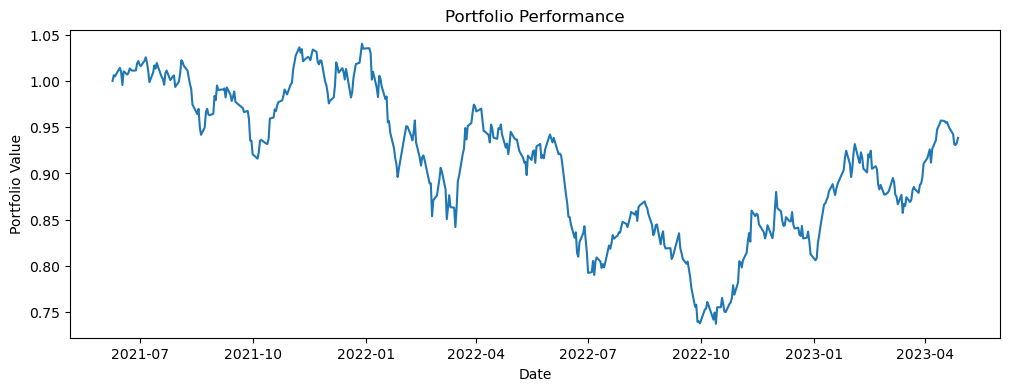

Max Drawdown: -0.2909971997914748
Turnover: 1.4614960636374998


In [101]:
# Load asset prices
loader = Loader("./sample.csv")

# Create a Pipeline object
#pipeline = Pipeline(...)

# Create a Backtest object
backtest = Backtest(
    pipeline=pipe,
    loader=loader,
    start_date="2021-06-09",
    end_date="2023-05-01",
)


# Run the backtest
backtest.run_backtest()

# Plot the performance
backtest.plot_performance()

# Calculate maximum drawdown and turnover
max_drawdown = backtest.calculate_maximum_drawdown()
turnover = backtest.calculate_turnover()

print("Max Drawdown:", max_drawdown)
print("Turnover:", turnover)

# 잠시 샘플 데이터 크롤링해서 만들기

In [33]:
import pandas as pd
import FinanceDataReader as fdr
# 회사채 : 136340, 국공채 : 272560, 미국주식 : 379780, 한국주식 : 148020
# 주식 : 189400 채권 : 267440
ticker=['189400', '267440', '379780', '148020', '136340', '272580']

In [34]:
def get_ticker_data(tickers):
    df = dict()
    name = ['Stocks', 'Bonds', 'US Stocks', 'Korean Stocks', 'Government Bonds', 'Corporate Bonds']
    for i in range(len(name)):
        df[name[i]] = fdr.DataReader(tickers[i], '2018')['Close']
        
    return pd.DataFrame(df).dropna()

In [78]:
# 백업용
"""
    def run_backtest(self):
        prices = self.loader.load_data(self.start_date, self.end_date)
        rebalancing_dates = self._generate_rebalancing_dates(prices.index)

        asset_weights = []
        portfolio_value = [1]
        
        for i, rebalancing_date in enumerate(rebalancing_dates[:-1]):
            prices_sub = prices.loc[:rebalancing_date]
            allocations = self.pipeline.run()

            asset_weights.append(allocations)
            start_date = self.previous_business_day(rebalancing_date)
            end_date = rebalancing_dates[i + 1]

            prices_period = prices.loc[start_date:end_date]
            period_returns = prices_period.pct_change().dropna()
            #print(period_returns)
            period_returns['portfolio'] = np.dot(period_returns, list(allocations.values()))

            # Apply rebalancing_fee
            if i > 0:
                period_returns.loc[rebalancing_date, 'portfolio'] -= self.rebalancing_fee

            period_cumulative_returns = (1 + period_returns).cumprod()
            period_portfolio_value = portfolio_value[-1] * period_cumulative_returns['portfolio']
            print(period_portfolio_value[1:])
            portfolio_value.extend(period_portfolio_value[1:].values)

        self.portfolio_value = pd.Series(portfolio_value, index=prices.index)
        self.returns = self.portfolio_value.pct_change().dropna()
        self.asset_weights = pd.DataFrame(asset_weights, index=rebalancing_dates[:-1], columns=prices.columns)
"""

"\n    def run_backtest(self):\n        prices = self.loader.load_data(self.start_date, self.end_date)\n        rebalancing_dates = self._generate_rebalancing_dates(prices.index)\n\n        asset_weights = []\n        portfolio_value = [1]\n        \n        for i, rebalancing_date in enumerate(rebalancing_dates[:-1]):\n            prices_sub = prices.loc[:rebalancing_date]\n            allocations = self.pipeline.run()\n\n            asset_weights.append(allocations)\n            start_date = self.previous_business_day(rebalancing_date)\n            end_date = rebalancing_dates[i + 1]\n\n            prices_period = prices.loc[start_date:end_date]\n            period_returns = prices_period.pct_change().dropna()\n            #print(period_returns)\n            period_returns['portfolio'] = np.dot(period_returns, list(allocations.values()))\n\n            # Apply rebalancing_fee\n            if i > 0:\n                period_returns.loc[rebalancing_date, 'portfolio'] -= self.rebalancing

In [35]:
sample = get_ticker_data(ticker)
sample.to_csv('sample.csv')

C:\ProgramData\Anaconda3\envs\test\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fchart.stock.naver.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\ProgramData\Anaconda3\envs\test\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fchart.stock.naver.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\ProgramData\Anaconda3\envs\test\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fchart.stock.naver.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Prog

In [10]:
from typing import Any

def test(**params: Any):
    return params
    
c = test(a = 'a', b = 1)

In [13]:
[i for i in c.keys()]

['a', 'b']